**Multiclass semantic segmentation**


The dataset used represents the XRM (tomography) scan of a sandstone cylinder of size about 2 mm diameter. The 
dark regions inside the sandstone represents air/void. In addition to air, the region has 3 regions of interest that need to be segmented, quartz (light grey), clay (darker grey with texture), and pyrite (bright pixels). Clay and quartz are minority classes but since quartz appears in bright, it is easier to segment. Please read the Readme document for more information. 
https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view?usp=sharing

In [6]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

## Extract patches from large images and masks for semantic segmentation

In [7]:
!pwd

/content


In [8]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from patchify import patchify
import tifffile as tiff

We locate the images and masks provided in the main folder: [images_256_256_256.tif](https://github.com/javier-marti-isasi/Multiclass-semantic-segmentation-using-U-Net/raw/main/data/images_256_256_256.tif) and [masks_256_256_256.tif](https://github.com/javier-marti-isasi/Multiclass-semantic-segmentation-using-U-Net/raw/main/data/masks_256_256_256.tif). Tif files include 256 images of 256 x 256. We will cut them in 128 x 128 images using patchify.

In [10]:
large_image_stack = tiff.imread(['images_256_256_256.tif'])
large_mask_stack = tiff.imread('masks_256_256_256.tif')

In [11]:
large_image_stack.shape

(256, 256, 256)

We extract patches from large images and masks and we save them. For this, we have to create the following routes:
* 'content/patches/images/'
* 'content/patches/masks/'

In [12]:
# We extract patches from large images and we save them
for img in range(large_image_stack.shape[0]):
  large_image = large_image_stack[img]
  patches_img = patchify(large_image, (128,128), step=128)

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img=patches_img[i,j,:,:]
      tiff.imwrite('patches/images/' + 'image_' + str(img) + '_' + str(i)+str(j)+ '.tif', single_patch_img)

In [13]:
# We extract patches from large masks and we save them.
for mask in range(large_mask_stack.shape[0]):
  large_mask = large_mask_stack[mask]
  patches_mask = patchify(large_mask, (128,128), step=128)

  for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
      single_patch_mask=patches_mask[i,j,:,:]
      tiff.imwrite('patches/masks/' + 'mask_' + str(mask) + '_' + str(i)+str(j)+ '.tif', single_patch_mask)

## Load data

In [14]:
# Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 # Number of classes for segmentation
num_images = 1024  # Total 1024 available

In [15]:
image_directory = '/patches/images/'
mask_directory = '/patches/masks/'

Load images and masks in order so they match

In [16]:
image_names = glob.glob("/content/patches/images/*.tif")
print(image_names)

['/content/patches/images/image_245_10.tif', '/content/patches/images/image_135_10.tif', '/content/patches/images/image_25_10.tif', '/content/patches/images/image_169_10.tif', '/content/patches/images/image_236_00.tif', '/content/patches/images/image_20_11.tif', '/content/patches/images/image_194_11.tif', '/content/patches/images/image_82_00.tif', '/content/patches/images/image_117_11.tif', '/content/patches/images/image_5_00.tif', '/content/patches/images/image_12_00.tif', '/content/patches/images/image_71_10.tif', '/content/patches/images/image_131_11.tif', '/content/patches/images/image_85_10.tif', '/content/patches/images/image_203_11.tif', '/content/patches/images/image_35_00.tif', '/content/patches/images/image_50_00.tif', '/content/patches/images/image_45_10.tif', '/content/patches/images/image_247_00.tif', '/content/patches/images/image_64_11.tif', '/content/patches/images/image_173_01.tif', '/content/patches/images/image_137_01.tif', '/content/patches/images/image_42_10.tif', 

In [17]:
image_names.sort()
print(image_names)

['/content/patches/images/image_0_00.tif', '/content/patches/images/image_0_01.tif', '/content/patches/images/image_0_10.tif', '/content/patches/images/image_0_11.tif', '/content/patches/images/image_100_00.tif', '/content/patches/images/image_100_01.tif', '/content/patches/images/image_100_10.tif', '/content/patches/images/image_100_11.tif', '/content/patches/images/image_101_00.tif', '/content/patches/images/image_101_01.tif', '/content/patches/images/image_101_10.tif', '/content/patches/images/image_101_11.tif', '/content/patches/images/image_102_00.tif', '/content/patches/images/image_102_01.tif', '/content/patches/images/image_102_10.tif', '/content/patches/images/image_102_11.tif', '/content/patches/images/image_103_00.tif', '/content/patches/images/image_103_01.tif', '/content/patches/images/image_103_10.tif', '/content/patches/images/image_103_11.tif', '/content/patches/images/image_104_00.tif', '/content/patches/images/image_104_01.tif', '/content/patches/images/image_104_10.t

In [18]:
image_names_subset = image_names[0:num_images] # We take the first 1000 images

In [19]:
images = [cv2.imread(img, 0) for img in image_names_subset]

In [20]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

Read masks the same way.

In [21]:
mask_names = glob.glob("/content/patches/masks/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [22]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1024, 128, 128, 1)
Mask data shape is:  (1024, 128, 128, 1)
Max pixel value in image is:  255
Labels in the mask are :  [0 1 2 3]


## Preprocess data

In [23]:
# Normalize images
image_dataset = image_dataset /255.  # Can also normalize or scale using MinMax scaler

In [24]:
# Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2, random_state = 42)

# Split validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(655, 128, 128, 1)
(655, 128, 128, 1)
(164, 128, 128, 1)
(164, 128, 128, 1)
(205, 128, 128, 1)
(205, 128, 128, 1)


We need to convert mask partitions to one-hot-encoding to correspond the 4 channels of the output of the U-Net model.

In [26]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [27]:
print(y_train_cat.shape)
print(y_test_cat.shape)
print(y_val_cat.shape)

(655, 128, 128, 4)
(205, 128, 128, 4)
(164, 128, 128, 4)


## Visualize some data

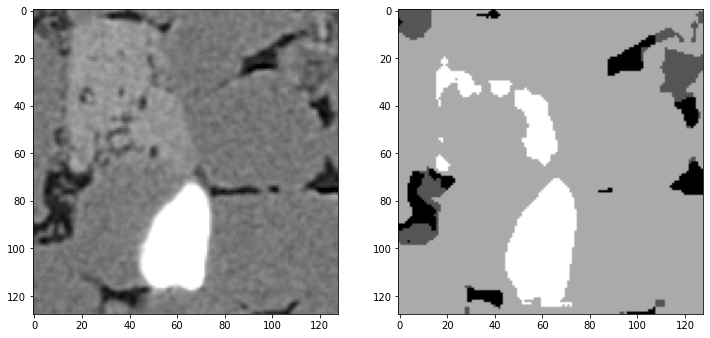

In [28]:
# Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

## Building U-Net model

In [29]:
# Building Unet by dividing encoder and decoder into blocks
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)
    return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# Decoder block
# Skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  # Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [30]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [31]:
model = build_unet(input_shape, n_classes=4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

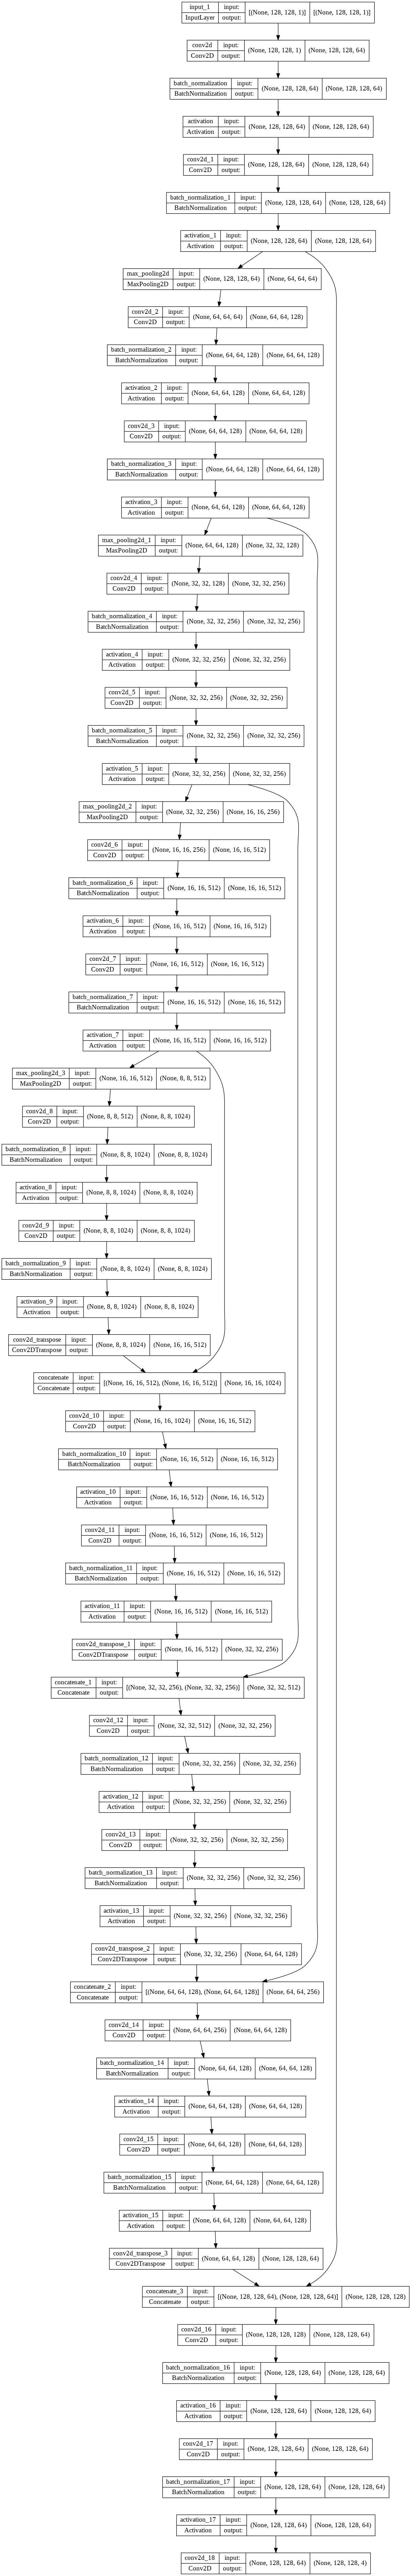

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training the model

In [33]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_val, y_val_cat), 
                    shuffle=False)

Epoch 1/50
41/41 [==============================] - 38s 387ms/step - loss: 0.3977 - accuracy: 0.9128 - val_loss: 1.9549 - val_accuracy: 0.1582
Epoch 2/50
41/41 [==============================] - 10s 238ms/step - loss: 0.1644 - accuracy: 0.9566 - val_loss: 0.6641 - val_accuracy: 0.8287
Epoch 3/50
41/41 [==============================] - 10s 240ms/step - loss: 0.1297 - accuracy: 0.9601 - val_loss: 0.7352 - val_accuracy: 0.8287
Epoch 4/50
41/41 [==============================] - 10s 243ms/step - loss: 0.1128 - accuracy: 0.9627 - val_loss: 0.8172 - val_accuracy: 0.8287
Epoch 5/50
41/41 [==============================] - 10s 248ms/step - loss: 0.1021 - accuracy: 0.9648 - val_loss: 0.8144 - val_accuracy: 0.8287
Epoch 6/50
41/41 [==============================] - 10s 249ms/step - loss: 0.0953 - accuracy: 0.9662 - val_loss: 0.8826 - val_accuracy: 0.8287
Epoch 7/50
41/41 [==============================] - 10s 253ms/step - loss: 0.0881 - accuracy: 0.9678 - val_loss: 0.9470 - val_accuracy: 0.8288

In [34]:
# Save the model for future use
model.save('/content/model.hdf5')

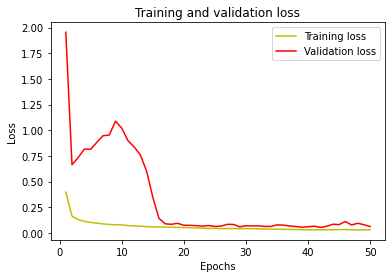

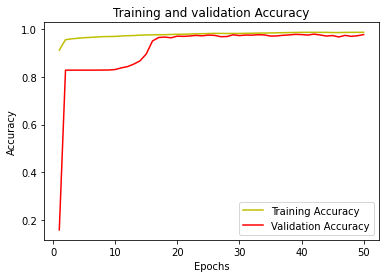

In [35]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model evaluation

In [36]:
# Load previously saved model
from keras.models import load_model
model = load_model("/content/model.hdf5", compile=False)

First, we make predictions on the unseen test partition.

In [37]:
# We make predictions
y_pred=model.predict(X_test)
y_pred.shape

(205, 128, 128, 4)

In [38]:
# Converts 4 channel predictions to a clasification
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(205, 128, 128)

We evaluate the model with the Intersection over union (IOU) metric on the onseen test partition.

In [39]:
# Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8797648


We evaluate the model with the Intersection over union (IOU) metric for each class.

In [40]:
# To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[2.948580e+05 8.657000e+03 4.240000e+03 0.000000e+00]
 [5.837000e+03 1.812470e+05 2.020100e+04 0.000000e+00]
 [5.954000e+03 2.231200e+04 2.733677e+06 8.247000e+03]
 [0.000000e+00 9.000000e+00 3.303000e+03 7.017800e+04]]
IoU for class1 is:  0.9227404
IoU for class2 is:  0.7607014
IoU for class3 is:  0.97703415
IoU for class4 is:  0.85858303


We plot the predicted segmentation of a random test image:

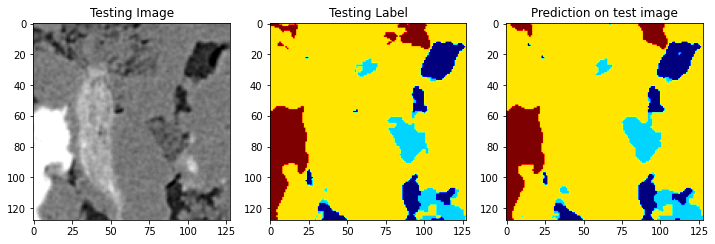

In [45]:
# Predict on a few images
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()